<a href="https://colab.research.google.com/github/nihemelandu/customer-lifetime-value/blob/main/Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
import numpy as np

In [33]:
df = pd.read_csv("/content/sample_data/customer_analytics_master.csv")

In [34]:
df.shape

(200367, 23)

In [35]:
df.head()

,customer_id,order_id,registration_date,customer_segment,acquisition_channel,account_status,order_date,order_value,order_status,quantity,...,base_price,effective_date,price,pricing_strategy,end_date,promotion_name,promotion_type,discount_percentage,start_date,end_date_1
0,10353,ord_bb707091,2022-03-02 00:00:00,high_value,direct,active,2023-03-16,142.57,delivered,2.0,...,169.94,2022-06-19,169.94,regular,NaN,NaN,NaN,NaN,NaN,NaN
1,10353,ord_bb707091,2022-03-02 00:00:00,high_value,direct,active,2023-03-16,142.57,delivered,2.0,...,169.94,2022-10-13,160.97,demand_based,NaN,NaN,NaN,NaN,NaN,NaN
2,10353,ord_bb707091,2022-03-02 00:00:00,high_value,direct,active,2023-03-16,142.57,delivered,2.0,...,169.94,2023-01-18,156.94,competitive_match,NaN,NaN,NaN,NaN,NaN,NaN
3,10353,ord_bb707091,2022-03-02 00:00:00,high_value,direct,active,2023-03-16,142.57,delivered,2.0,...,169.94,2023-05-09,114.02,clearance,NaN,NaN,NaN,NaN,NaN,NaN
4,10353,ord_e2ff4705,2022-03-02 00:00:00,high_value,direct,active,2023-12-02,206.62,shipped,2.0,...,143.79,2021-05-22,143.79,regular,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
#df.loc[df.account_status == 'inactive']
df.customer_id.nunique()

25000

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200367 entries, 0 to 200366
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   customer_id          200367 non-null  int64  
 1   order_id             189798 non-null  object 
 2   registration_date    200367 non-null  object 
 3   customer_segment     200367 non-null  object 
 4   acquisition_channel  200367 non-null  object 
 5   account_status       200367 non-null  object 
 6   order_date           189798 non-null  object 
 7   order_value          189798 non-null  float64
 8   order_status         189798 non-null  object 
 9   quantity             189798 non-null  float64
 10  unit_price           189798 non-null  float64
 11  category             189798 non-null  object 
 12  price_tier           189798 non-null  object 
 13  base_price           189798 non-null  float64
 14  effective_date       189798 non-null  object 
 15  price            

# **We want to understand both the average customer behavior and how it changes before someone churns**

## **Question 1**: What is the typical time between purchases for active customers?

In [38]:
df.order_status.unique()

array(['delivered', 'shipped', 'processing', nan], dtype=object)

In [39]:
# 1. Filter for active customers with valid order status
df_active = df.loc[(df.order_status.isin(['shipped', 'delivered', 'processing'])) & (df.account_status == 'active'),:].copy()
print(f"# of Active customers = {df_active.customer_id.nunique()} | # of orders {len(df_active)}")

# of Active customers = 12472 | # of orders 166067


In [40]:
# 2. Convert 'order_date' to datetime
df_active['order_date'] = pd.to_datetime(df_active['order_date'])

In [41]:
# 3. Sort by customer and order date
df_active = df_active.sort_values(by=['customer_id', 'order_date'])

In [42]:
# 4. Calculate time between successive orders
df_active['days_between_orders'] = df_active.groupby('customer_id')['order_date'].diff().dt.days

In [43]:
avg_days_per_customer = df_active.groupby('customer_id')['days_between_orders'].mean()
typical_time = avg_days_per_customer.mean()
typical_time

np.float64(10.22743176383384)

In [14]:
df_active.days_between_orders.describe()

,days_between_orders
count,153595.000000
mean,12.680341
std,50.721821
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,779.000000


In [45]:
days_clean = df_active['days_between_orders'].dropna()

# Create intervals and count
intervals = pd.cut(days_clean,
                  bins=[0, 7, 30, 60, 90, 180, 365, np.inf],
                  labels=['0-7 days', '8-30 days', '31-60 days', '61-90 days',
                         '91-180 days', '181-365 days', '365+ days'],
                  include_lowest=True)

# Count frequency in each interval
interval_counts = intervals.value_counts(normalize=True)
interval_counts.sort_index(inplace=True)
interval_counts = interval_counts.reset_index()
interval_counts.columns = ['Interval', 'Count']
interval_counts

,Interval,Count
0,0-7 days,0.894580
1,8-30 days,0.018777
2,31-60 days,0.019903
3,61-90 days,0.015059
4,91-180 days,0.028966
5,181-365 days,0.018653
6,365+ days,0.004063


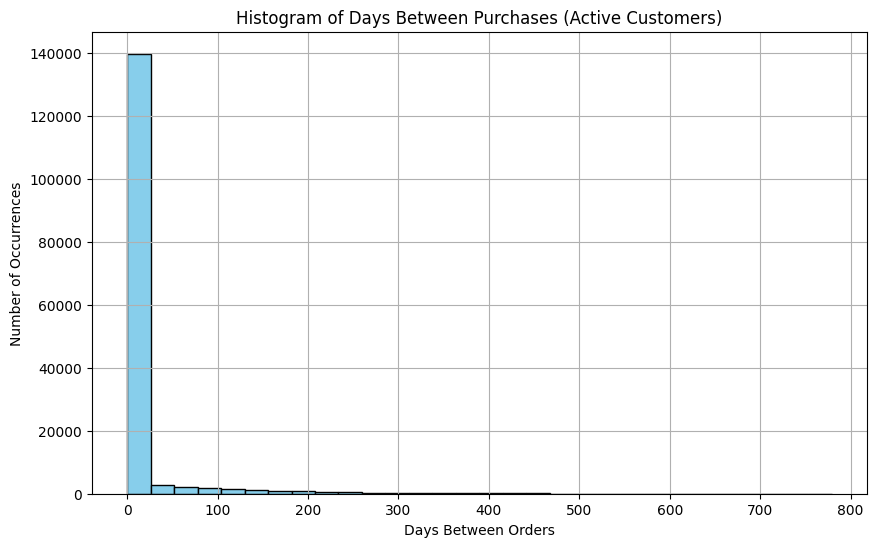

In [46]:
import matplotlib.pyplot as plt

# Drop NaN values from the 'days_between_orders' column
days_between = df_active['days_between_orders'].dropna()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(days_between, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Days Between Purchases (Active Customers)')
plt.xlabel('Days Between Orders')
plt.ylabel('Number of Occurrences')
plt.grid(True)
plt.show()


- Dominant Pattern: 0-7 days (89% of re-orders)

29,128 out of 32,728 total intervals are within a week
This suggests most active customers are very frequent purchasers

- Sharp Drop-off After 7 Days:

Only about 11% of purchase intervals are longer than 7 days
There's a dramatic behavioral difference between frequent and infrequent buyers

- Long Tail Distribution:

Small but notable group of customers with 365+ day gaps (145 intervals)
These might be customers on the verge of churning. Who are these customers? Were they once, frequent buyers?


### What This Tells Us:

1.   Two distinct customer behaviors:

- Frequent buyers (0-7 days) - the vast majority
- Occasional buyers (everything else) - much smaller group

2.   Potential data characteristics:

- Frequent buying customers dominating the dataset(are they also high value?)
- Or customers making multiple small orders instead of fewer large orders


3.   For churn prediction:

- Are there repeat patterns for the identified intervals?


This distribution suggests that frequent purchasing (within a week) is the norm. But are weekly purchasing a distinct group from the others?

What are the counts for distinct intervals and the distribution?

In [47]:
# Filter for customers who have 0-7 day intervals
short_interval_customers = df_active[df_active['days_between_orders'].between(0, 7, inclusive='both')]['customer_id'].unique()
n_short_interval_customers = len(short_interval_customers)

print(f"Number of customers with 0-7 day intervals: {len(short_interval_customers)}")

short_interval_transactions = df_active[df_active['days_between_orders'].between(0, 7, inclusive='both')]
print(f"Number of transactions with 0-7 day intervals: {len(short_interval_transactions)}")

# For each of these customers, analyze their interval patterns
pattern_analysis = []

for customer in short_interval_customers:
    customer_data = df_active[df_active['customer_id'] == customer]['days_between_orders'].dropna()
    #print(len(customer_data))
    if len(customer_data) > 0:  # Customer has at least one interval
        # Count intervals in different ranges
        intervals_0_7 = sum((customer_data >= 0) & (customer_data <= 7))
        intervals_8_30 = sum((customer_data > 7) & (customer_data <= 30))
        intervals_31_plus = sum(customer_data > 30)
        total_intervals = len(customer_data)

        # Calculate percentage of 0-7 day intervals for this customer
        pct_short_intervals = (intervals_0_7 / total_intervals) * 100 if total_intervals > 0 else 0

        pattern_analysis.append({
            'customer_id': customer,
            'total_intervals': total_intervals,
            'intervals_0_7': intervals_0_7,
            'intervals_8_30': intervals_8_30,
            'intervals_31_plus': intervals_31_plus,
            'pct_short_intervals': pct_short_intervals
        })

patterns_df = pd.DataFrame(pattern_analysis)
#print(patterns_df.head())
# Analyze the patterns
print("\nPattern Analysis for 0-7 Day Interval Customers:")
print(f"Customers with 100% short intervals: {(patterns_df['pct_short_intervals'] == 100).sum()/n_short_interval_customers}")
print(f"Customers with [75% - 100%) short intervals: {((patterns_df['pct_short_intervals'] >= 75) & (patterns_df['pct_short_intervals'] < 100)).sum()/n_short_interval_customers}")
print(f"Customers with [50% - 75%) short intervals: {((patterns_df['pct_short_intervals'] >= 50) & (patterns_df['pct_short_intervals'] < 75)).sum()/n_short_interval_customers}")
print(f"Customers with < 50% short intervals: {(patterns_df['pct_short_intervals'] < 50).sum()/n_short_interval_customers}")


# Show distribution of short interval percentages
print("\nDistribution of % of short intervals per customer:")
print(patterns_df['pct_short_intervals'].describe())
print(f"\nAverage % of short intervals per customer: {patterns_df['pct_short_intervals'].mean():.1f}%")
print(f"Median % of short intervals per customer: {patterns_df['pct_short_intervals'].median():.1f}%")

Number of customers with 0-7 day intervals: 12472
Number of transactions with 0-7 day intervals: 137403

Pattern Analysis for 0-7 Day Interval Customers:
Customers with 100% short intervals: 0.41853752405388067
Customers with [75% - 100%) short intervals: 0.5533194355355997
Customers with [50% - 75%) short intervals: 0.028143040410519564
Customers with < 50% short intervals: 0.0

Distribution of % of short intervals per customer:
count    12472.000000
mean        91.742085
std          8.613321
min         60.000000
25%         85.714286
50%         92.592593
75%        100.000000
max        100.000000
Name: pct_short_intervals, dtype: float64

Average % of short intervals per customer: 91.7%
Median % of short intervals per customer: 92.6%


In [49]:
# Filter for customers who have 0-7 day intervals
short_interval_customers = df_active[df_active['days_between_orders'].between(0, 7, inclusive='both')]['customer_id'].unique()
n_short_interval_customers = len(short_interval_customers)
n_short_interval_transactions = len(df_active[df_active['days_between_orders'].between(0, 7, inclusive='both')])

print(f"Number of customers with 0-7 day intervals: {len(short_interval_customers)}")

# For each of these customers, analyze their interval patterns
pattern_analysis = []

for customer in short_interval_customers:
    customer_data = df_active[df_active['customer_id'] == customer]['days_between_orders'].dropna()
    #print(len(customer_data))
    if len(customer_data) > 0:  # Customer has at least one interval
        # Count intervals in different ranges
        intervals_0_7 = sum((customer_data >= 0) & (customer_data <= 7))
        intervals_8_30 = sum((customer_data > 7) & (customer_data <= 30))
        intervals_31_plus = sum(customer_data > 30)
        total_intervals = len(customer_data)

        # Calculate percentage of 0-7 day intervals for this customer
        pct_short_intervals = (intervals_0_7 / total_intervals) * 100 if total_intervals > 0 else 0

        pattern_analysis.append({
            'customer_id': customer,
            'total_intervals': total_intervals,
            'intervals_0_7': intervals_0_7,
            'intervals_8_30': intervals_8_30,
            'intervals_31_plus': intervals_31_plus,
            'pct_short_intervals': pct_short_intervals
        })

patterns_df = pd.DataFrame(pattern_analysis)
#print(patterns_df.head())
# Analyze the patterns
print("\nPattern Analysis for 0-7 Day Interval Customers:")
print(f"Customers with 100% short intervals: {(patterns_df['pct_short_intervals'] == 100).sum()/n_short_interval_customers}")
print(f"Customers with [75% - 100%) short intervals: {((patterns_df['pct_short_intervals'] >= 75) & (patterns_df['pct_short_intervals'] < 100)).sum()/n_short_interval_customers}")
print(f"Customers with [50% - 75%) short intervals: {((patterns_df['pct_short_intervals'] >= 50) & (patterns_df['pct_short_intervals'] < 75)).sum()/n_short_interval_customers}")
print(f"Customers with < 50% short intervals: {(patterns_df['pct_short_intervals'] < 50).sum()/n_short_interval_customers}")


# Show distribution of short interval percentages
print("\nDistribution of % of short intervals per customer:")
print(patterns_df['pct_short_intervals'].describe())
print(f"\nAverage % of short intervals per customer: {patterns_df['pct_short_intervals'].mean():.1f}%")
print(f"Median % of short intervals per customer: {patterns_df['pct_short_intervals'].median():.1f}%")

Number of customers with 0-7 day intervals: 12472

Pattern Analysis for 0-7 Day Interval Customers:
Customers with 100% short intervals: 0.41853752405388067
Customers with [75% - 100%) short intervals: 0.5533194355355997
Customers with [50% - 75%) short intervals: 0.028143040410519564
Customers with < 50% short intervals: 0.0

Distribution of % of short intervals per customer:
count    12472.000000
mean        91.742085
std          8.613321
min         60.000000
25%         85.714286
50%         92.592593
75%        100.000000
max        100.000000
Name: pct_short_intervals, dtype: float64

Average % of short intervals per customer: 91.7%
Median % of short intervals per customer: 92.6%


Approximately, 42% of customers always made daily or weekly purchase, while approximately 58% of customers had at least 60% of their purchases made daily or weekly.

This tells us that all customers made daily or weekly purchases. But we know that approximately 90% of transactions were made daily or weekly. Hence, who are those customers who made daily or weekly purchase, and also had days between purchases that exceeded a week?

In [51]:
total_active_customers = df_active['customer_id'].nunique()

# From your previous analysis
n_always_frequent = int(12472 * 0.41853752405388067)  # 100% short intervals
n_never_frequent = total_active_customers - 12472      # Never had 0-7 day intervals

frequent_customers = total_active_customers - n_never_frequent  # Have at least one 0-7 day interval
overlap_customers = total_active_customers - n_always_frequent  # Mixed + Never frequent

print(f"=== CUSTOMER BREAKDOWN ===")
print(f"Total active customers: {total_active_customers:,}")
print(f"")
print(f"n_always_frequent: {n_always_frequent:,} ({(n_always_frequent/total_active_customers)*100:.1f}%)")
print(f"n_never_frequent: {n_never_frequent:,} ({(n_never_frequent/total_active_customers)*100:.1f}%)")
print(f"frequent_customers: {frequent_customers:,} ({(frequent_customers/total_active_customers)*100:.1f}%)")
print(f"overlap_customers: {overlap_customers:,} ({(overlap_customers/total_active_customers)*100:.1f}%)")
print(f"")
print(f"Mixed pattern customers: {overlap_customers - n_never_frequent:,}")

=== CUSTOMER BREAKDOWN ===
Total active customers: 12,472

n_always_frequent: 5,220 (41.9%)
n_never_frequent: 0 (0.0%)
frequent_customers: 12,472 (100.0%)
overlap_customers: 7,252 (58.1%)

Mixed pattern customers: 7,252


100% of active customers make daily/weekly purchases at some point, but 58% have mixed patterns.


Let's analyze the trends over time for both groups:

In [53]:
# Get customer IDs for each group
always_frequent_ids = patterns_df[patterns_df['pct_short_intervals'] == 100]['customer_id'].tolist()
mixed_pattern_ids = patterns_df[patterns_df['pct_short_intervals'] < 100]['customer_id'].tolist()

# Create time series analysis
import matplotlib.pyplot as plt
import pandas as pd

# Function to analyze purchase patterns over time
def analyze_customer_trends(customer_ids, group_name):
    group_data = df_active[df_active['customer_id'].isin(customer_ids)].copy()

    # Create monthly aggregation
    group_data['year_month'] = group_data['order_date'].dt.to_period('M')

    monthly_stats = group_data.groupby('year_month').agg({
        'customer_id': 'nunique',  # Active customers per month
        'days_between_orders': ['mean', 'median'],  # Average purchase intervals
        'order_value': 'mean'  # Average order value
    }).round(2)

    monthly_stats.columns = ['active_customers', 'avg_days_between', 'median_days_between', 'avg_order_value']
    monthly_stats['group'] = group_name

    return monthly_stats


In [57]:
mixed_pattern_trends.head()

,active_customers,avg_days_between,median_days_between,avg_order_value,group
year_month,,,,,
2022-03,225,0.18,0.0,73.12,Mixed Pattern
2022-04,239,1.02,0.0,81.34,Mixed Pattern
2022-05,296,2.11,0.0,73.66,Mixed Pattern
2022-06,326,3.12,0.0,79.02,Mixed Pattern
2022-07,324,4.85,0.0,79.40,Mixed Pattern


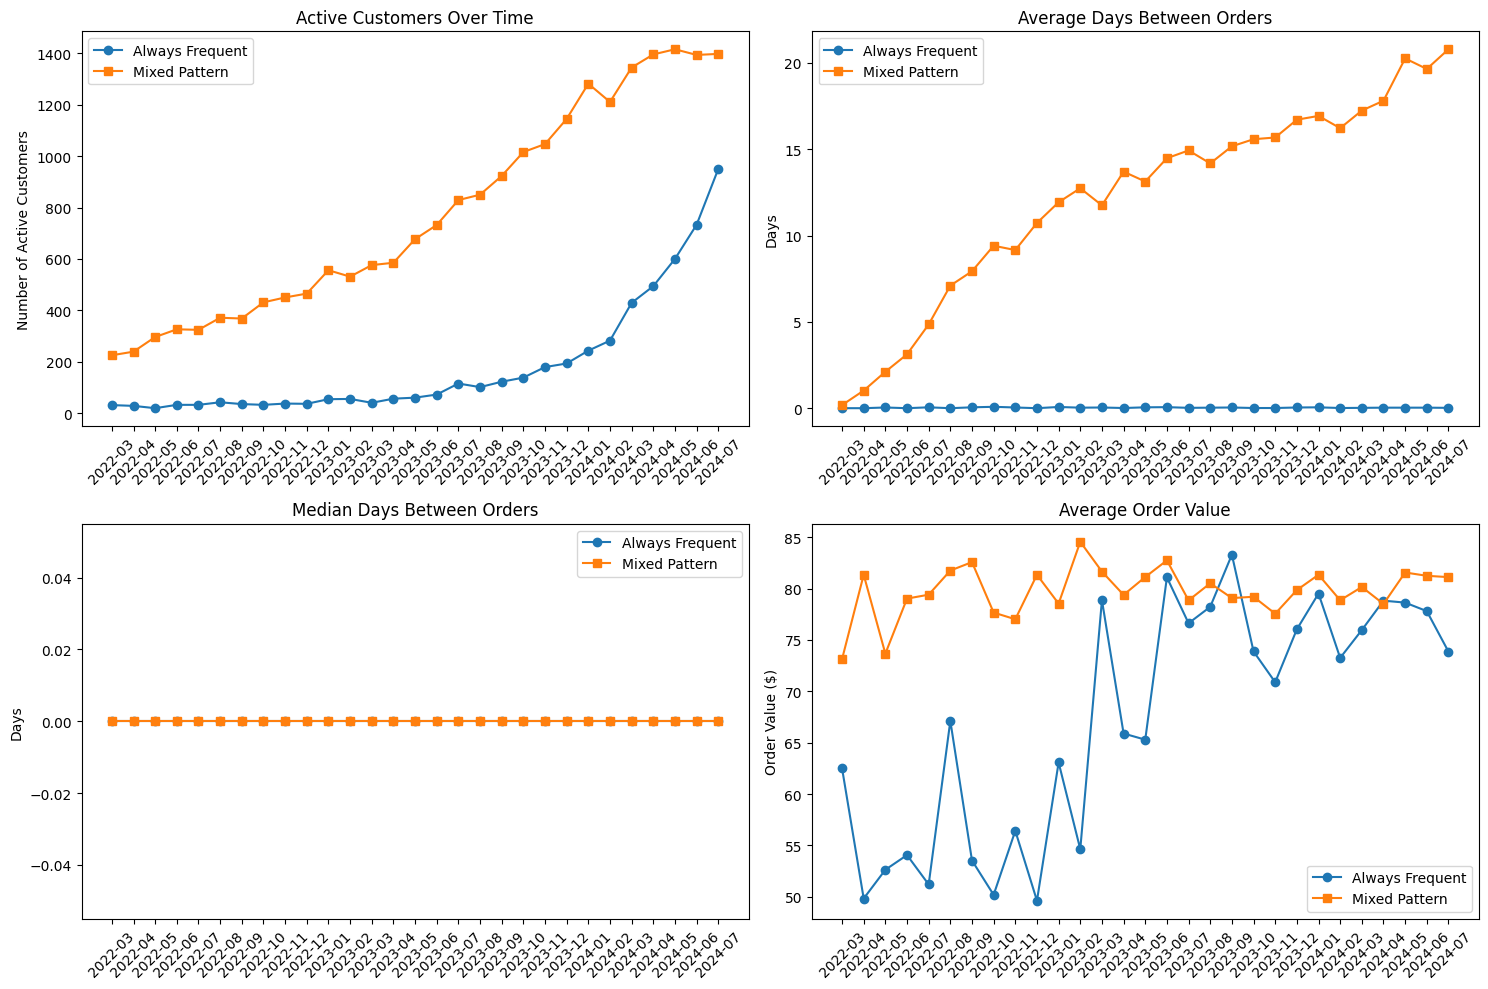

In [60]:
# Analyze both groups
always_frequent_trends = analyze_customer_trends(always_frequent_ids, 'Always Frequent')
mixed_pattern_trends = analyze_customer_trends(mixed_pattern_ids, 'Mixed Pattern')

# Plot trends
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Active customers over time
axes[0,0].plot(always_frequent_trends.index.astype(str), always_frequent_trends['active_customers'],
               label='Always Frequent', marker='o')
axes[0,0].plot(mixed_pattern_trends.index.astype(str), mixed_pattern_trends['active_customers'],
               label='Mixed Pattern', marker='s')
axes[0,0].set_title('Active Customers Over Time')
axes[0,0].set_ylabel('Number of Active Customers')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=45)

# Plot 2: Average days between orders
axes[0,1].plot(always_frequent_trends.index.astype(str), always_frequent_trends['avg_days_between'],
               label='Always Frequent', marker='o')
axes[0,1].plot(mixed_pattern_trends.index.astype(str), mixed_pattern_trends['avg_days_between'],
               label='Mixed Pattern', marker='s')
axes[0,1].set_title('Average Days Between Orders')
axes[0,1].set_ylabel('Days')
axes[0,1].legend()
axes[0,1].tick_params(axis='x', rotation=45)

# Plot 3: Median days between orders
axes[1,0].plot(always_frequent_trends.index.astype(str), always_frequent_trends['median_days_between'],
               label='Always Frequent', marker='o')
axes[1,0].plot(mixed_pattern_trends.index.astype(str), mixed_pattern_trends['median_days_between'],
               label='Mixed Pattern', marker='s')
axes[1,0].set_title('Median Days Between Orders')
axes[1,0].set_ylabel('Days')
axes[1,0].legend()
axes[1,0].tick_params(axis='x', rotation=45)

# Plot 4: Average order value
axes[1,1].plot(always_frequent_trends.index.astype(str), always_frequent_trends['avg_order_value'],
               label='Always Frequent', marker='o')
axes[1,1].plot(mixed_pattern_trends.index.astype(str), mixed_pattern_trends['avg_order_value'],
               label='Mixed Pattern', marker='s')
axes[1,1].set_title('Average Order Value')
axes[1,1].set_ylabel('Order Value ($)')
axes[1,1].legend()
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [61]:
# Print summary statistics
print("=== ALWAYS FREQUENT CUSTOMERS ===")
print(always_frequent_trends[['active_customers', 'avg_days_between', 'avg_order_value']].describe())
print("\n=== MIXED PATTERN CUSTOMERS ===")
print(mixed_pattern_trends[['active_customers', 'avg_days_between', 'avg_order_value']].describe())

=== ALWAYS FREQUENT CUSTOMERS ===
       active_customers  avg_days_between  avg_order_value
count         29.000000         29.000000        29.000000
mean         180.689655          0.029655        67.334483
std          237.288418          0.021955        11.444930
min           19.000000          0.000000        49.620000
25%           36.000000          0.010000        54.630000
50%           60.000000          0.030000        70.880000
75%          193.000000          0.040000        77.800000
max          950.000000          0.080000        83.290000

=== MIXED PATTERN CUSTOMERS ===
       active_customers  avg_days_between  avg_order_value
count         29.000000         29.000000        29.000000
mean         772.551724         12.223793        79.745862
std          410.004755          5.774864         2.457260
min          225.000000          0.180000        73.120000
25%          431.000000          9.160000        78.850000
50%          677.000000         13.700000       

### ***Key Insights***:

**Customer Volume:**

Mixed Pattern customers: ~773 active per month (much larger group)
Always Frequent customers: ~181 active per month (smaller but consistent group)

**Purchase Frequency (Critical Difference):**

- Always Frequent: 0.03 days average between orders (essentially same-day/next-day purchases!)
- Mixed Pattern: 12.2 days average between orders (about every 2 weeks)

**Order Value:**

- Always Frequent: \$67.33 average order value
- Mixed Pattern: $79.75 average order value (+18% higher per order)

**Business Implications:**

Always Frequent Customers (41.9%):

- Behavior: Make very small, frequent purchases (almost daily)
- Strategy: Likely buying consumables or making incremental purchases
Lower individual order value but much higher purchase frequency

Mixed Pattern Customers (58.1%):

- Behavior: Make larger, less frequent purchases (~every 2 weeks)
- Strategy: More planned, bulk purchasing behavior
Higher individual order value but lower purchase frequency

### How consistent is the frequency patterns between the groups?

## Question 2: What is the average spending per transaction?

In [21]:
df_active.order_status.unique()

array(['delivered', 'shipped', 'processing'], dtype=object)